In [1]:
%load_ext autoreload
%autoreload 2

## Demo
This is a simple walk-through on how to use our trained diffusion model to manipulate facial expressions.  
If datasets haven't been created, please run `python fer_data.py` to create the dataloaders.

### Library Import

In [2]:
import os
import wandb, torch
from ddpm_conditional import *
from fastcore.all import *
from modules import *
from embedding_utils import prepare_cnn, cnn_embed, prepare_vae, vae_embed
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import json
from PIL import Image

### Conditional Model

In [3]:

torch.cuda.empty_cache()
n = 7
device = "cuda"
# model = UNet_conditional(c_in=1, c_out=1, num_classes=7).to(device)
diffuser = Diffusion(noise_steps=1000, img_size=64, num_classes=7, c_in=1, c_out=1, use_sem=None)
ckpt = torch.load("./checkpoints/baseline/ckpt.pt")
ema_ckpt = torch.load("./checkpoints/baseline/ema_ckpt.pt")
diffuser.model.load_state_dict(ckpt)
diffuser.ema_model.load_state_dict(ema_ckpt)

vae_diffuser = Diffusion(noise_steps=1000, img_size=64, num_classes=10, c_in=1, c_out=1, use_sem='vae')
ckpt = torch.load("./checkpoints/vae/ckpt.pt")
ema_ckpt = torch.load("./checkpoints/vae/ema_ckpt.pt")
vae_diffuser.model.load_state_dict(ckpt)
vae_diffuser.ema_model.load_state_dict(ema_ckpt)

cnn_diffuser = Diffusion(noise_steps=1000, img_size=64, num_classes=10, c_in=1, c_out=1, use_sem='cnn')
ckpt = torch.load("./checkpoints/cnn/ckpt.pt")
ema_ckpt = torch.load("./checkpoints/cnn/ema_ckpt.pt")
cnn_diffuser.model.load_state_dict(ckpt)
cnn_diffuser.ema_model.load_state_dict(ema_ckpt)

03:56:41 - INFO: Created a temporary directory at /tmp/tmpt8v1bwgz
03:56:41 - INFO: Writing /tmp/tmpt8v1bwgz/_remote_module_non_scriptable.py


STATE DICT KEYS:  odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.8.weight', 'features.8.bias', 'features.9.weight', 'features.9.bias', 'features.9.running_mean', 'features.9.running_var', 'features.9.num_batches_tracked', 'features.11.weight', 'features.11.bias', 'features.12.weight', 'features.12.bias', 'features.12.running_mean', 'features.12.running_var', 'features.12.num_batches_tracked', 'features.16.weight', 'features.16.bias', 'features.17.weight', 'features.17.bias', 'features.17.running_mean', 'features.17.running_var', 'features.17.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'classifier.2.weight', 'classifier.2.bias'])


<All keys matched successfully>

In [4]:
# load validation images
from fer_data import fer_dataset
train_dataloader = torch.load('./dataset/fer_train_32.pt')
val_dataloader = torch.load('./dataset/fer_val_32.pt')

(3589,)
torch.Size([32, 1, 48, 48])


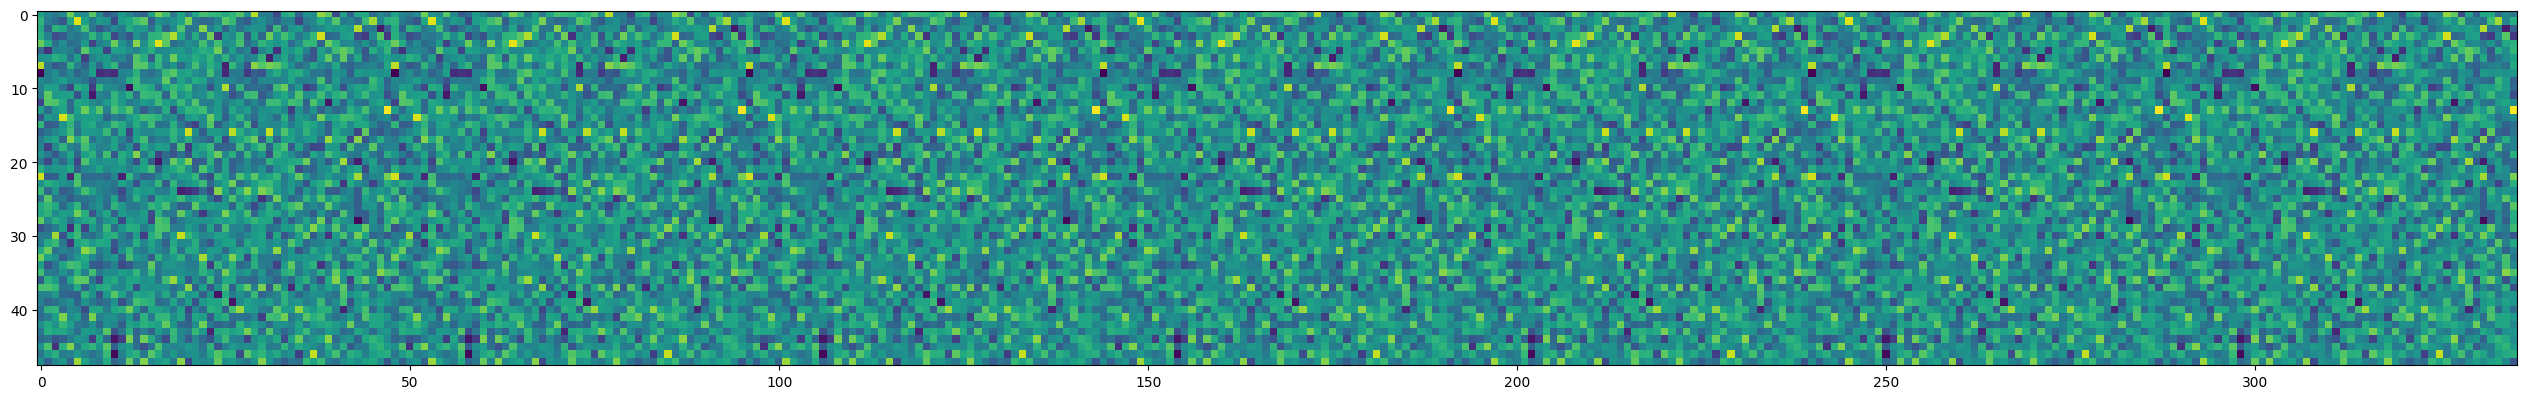

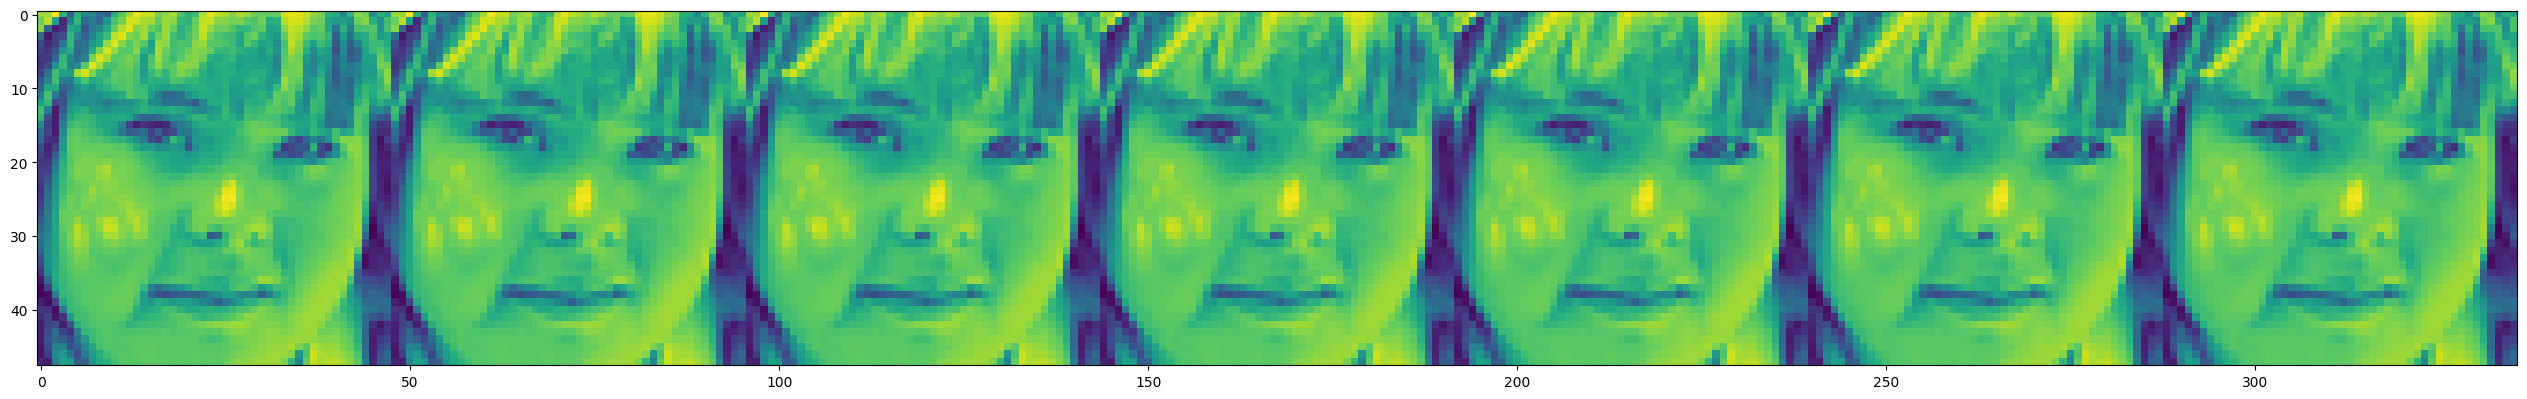

03:57:06 - INFO: Sampling 7 new images....


In [5]:
device = "cuda"
for idx, (img, label) in enumerate(val_dataloader):
    print(img.shape)
    # process input
    t = torch.randint(low=999, high=1000, size=(img.shape[0],))
    t = t.to(device)
    img = img.to(device).float()
    label = label.to(device)

    # get noised imgs
    x_t, noise = vae_diffuser.noise_images(img, t)

    # denoise for all labels
    for i in range(1, x_t.shape[0]):
        if label[i] != 6:
            continue
        z = x_t[i].unsqueeze(axis=0).expand(7, -1, -1, -1)
        x = img[i].unsqueeze(axis=0).expand(7, -1, -1, -1) # [7, 1, 48, 48]

        plot_images(z)
        plot_images(x)

        labels = torch.arange(7).long().to(device)

        sampled_images = diffuser.sample(use_ema=True, labels=labels, seed=0, init_noise=z)
        vae_sampled_images = vae_diffuser.sample(use_ema=True, labels=labels, seed=0, init_noise=z, ref_images=x)
        cnn_sampled_images = cnn_diffuser.sample(use_ema=True, labels=labels, seed=0, init_noise=z, ref_images=x)

        plot_images(sampled_images)
        plot_images(vae_sampled_images)
        plot_images(cnn_sampled_images)
        break
    break